# Core Imports

In [1]:
# Custom Imports
...

# File I/O
from pathlib import Path

# Cheminformatics
from rdkit import Chem

In [2]:
# Static Paths
RAW_DATA_PATH  = Path('raw_monomer_data')
PROC_DATA_PATH = Path('processed_monomer_data')
RXN_FILES_PATH = Path('rxn_smarts')
MONO_INFO_DIR  = Path('monomer_files_dup')

# File and chemistry type definitions

In [3]:
# defining reacting functional groups
reaction_pairs = {
    'NIPU' : ('cyclocarbonate', 'amine'),
    'urethane' : ('isocyanate', 'hydroxyl')
}
# chemistries = ('urethane', 'NIPU')
chemistries = [i for i in reaction_pairs.keys()]

# Building PDB files from monomer fragments

In [4]:
from polymerist.genutils.containers import RecursiveDict
from polymerist.genutils.fileutils.pathutils import asstrpath

from polymerist.monomers import MonomerGroup
from polymerist.polymers import building


pdb_dir = Path('pdb_files_dup')
pdb_dir.mkdir(exist_ok=True)

DOP = 10

failed = RecursiveDict()
for chemistry in chemistries:
    mono_src_dir = MONO_INFO_DIR / chemistry
    chem_dir = pdb_dir / chemistry
    chem_dir.mkdir(exist_ok=True)

    for mono_path in mono_src_dir.iterdir():
        monogrp = MonomerGroup.from_file(mono_path)
        try:
            polymer = building.build_linear_polymer(monomers=monogrp, DOP=DOP, sequence='AB')  
            savepath = chem_dir / f'{mono_path.stem}.pdb'
            building.mbmol_to_openmm_pdb(savepath, polymer)
            
            # polymer.save(asstrpath(savepath))
        except Exception as e:
            failed[chemistry][e.__class__.__name__][mono_path.stem] = monogrp

/home/timber/miniconda3/envs/polymerist_env/lib/python3.11/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/polymerist_env/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/timber/miniconda3/envs/polymerist_env/lib/python3.11/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/polymerist_env/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


No valid terminal monomer orientations defined; autogenerated orientations "{'cyclocarbonate_TERM': 'head', 'amine_TERM': 'tail'}"; USER SHOULD VERIFY THIS YIELDS A CHEMICALLY-VALID POLYMER!
No valid terminal monomer orientations defined; autogenerated orientations "{'cyclocarbonate_TERM': 'head', 'amine_TERM': 'tail'}"; USER SHOULD VERIFY THIS YIELDS A CHEMICALLY-VALID POLYMER!
No valid terminal monomer orientations defined; autogenerated orientations "{'cyclocarbonate_TERM': 'head', 'amine_TERM': 'tail'}"; USER SHOULD VERIFY THIS YIELDS A CHEMICALLY-VALID POLYMER!
No valid terminal monomer orientations defined; autogenerated orientations "{'cyclocarbonate_TERM': 'head', 'amine_TERM': 'tail'}"; USER SHOULD VERIFY THIS YIELDS A CHEMICALLY-VALID POLYMER!
No valid terminal monomer orientations defined; autogenerated orientations "{'cyclocarbonate_TERM': 'head', 'amine_TERM': 'tail'}"; USER SHOULD VERIFY THIS YIELDS A CHEMICALLY-VALID POLYMER!
No valid terminal monomer orientations define

In [5]:
failed

defaultdict(<function polymerist.genutils.containers.RecursiveDict.<locals>.<lambda>()>,
            {'NIPU': defaultdict(<function polymerist.genutils.containers.RecursiveDict.<locals>.<lambda>()>,
                         {'MBuildError': defaultdict(<function polymerist.genutils.containers.RecursiveDict.<locals>.<lambda>()>,
                                      {'NIPU_1': MonomerGroup(monomers={'cyclocarbonate_TERM': ['[#6D4+0:1](-[#8D2+0:2]-[#1D1+0:3])(-[#6D4+0:4](-[#8D2+0:5]-[#6D3+0:6](=[#8D1+0:7])-[*:132])(-[#1D1+0:8])-[#1D1+0:9])(-[#1D1+0:10])-[#6D4+0:11](-[#8D2+0:12]-[#6D3+0:15](-[#6D4+0:16](-[#6D4+0:18](-[#6D4+0:21](-[#6D4+0:24](-[#6D4+0:27](-[#6D4+0:30](-[#6D4+0:33](-[#6D4+0:36](-[#6D4+0:39]1(-[#6D4+0:42](-[#6D4+0:45](-[#6D4+0:51](-[#6D4+0:50](-[#6D4+0:43]-1(-[#6D4+0:48](-[#6D4+0:54](-[#6D4+0:61](-[#6D4+0:70](-[#6D4+0:79](-[#6D4+0:88](-[#6D4+0:97](-[#6D4+0:106](-[#6D3+0:112](=[#8D1+0:118])-[#8D2+0:119]-[#6D4+0:120](-[#6D4+0:121]1(-[#6D4+0:124](-[#8D2+0:127]-[#6D3+0:130](-[#8D

## Testing sanitization of monomers prior to mbuild conversion

In [9]:
from polymerist.rdutils import rdkdraw
from polymerist.rdutils import rdconvert
from polymerist.rdutils.amalgamation.bonding import hydrogenate_rdmol_ports
from polymerist.rdutils.labeling import molwise

from polymerist.monomers.substruct import specification


rdkdraw.set_rdkdraw_size(500, 3/2)
cvtr = rdconvert.SMILESConverter()

chemistry = 'urethane'
idx = 10

monogrp = MonomerGroup.from_file(MONO_INFO_DIR / chemistry / f'{chemistry}_{idx}.json')

mbmols = {}
def show(monogrp : MonomerGroup) -> None:
    for resname, mol in monogrp.iter_rdmols():
        mol = molwise.clear_atom_map_nums(mol, in_place=False)
        Chem.SanitizeMol(mol, sanitizeFlags=specification.SANITIZE_AS_KEKULE)
        print(resname)
        display(mol)

        mbmol, linker_ids = building.mbmol_from_mono_rdmol(mol)
        mbmols[resname] = mbmol
        # mbmol, ports = building.mbmol_from_mono_smarts(new_smarts)
        # prot_mol = hydrogenate_rdmol_ports(mol, in_place=False)

show(monogrp)

ArgumentError: Python argument types in
    rdkit.Chem.rdmolops.SanitizeMol(Mol)
did not match C++ signature:
    SanitizeMol(RDKit::ROMol {lvalue} mol, unsigned long sanitizeOps=rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_ALL, bool catchErrors=False)

isocyanate_TERM


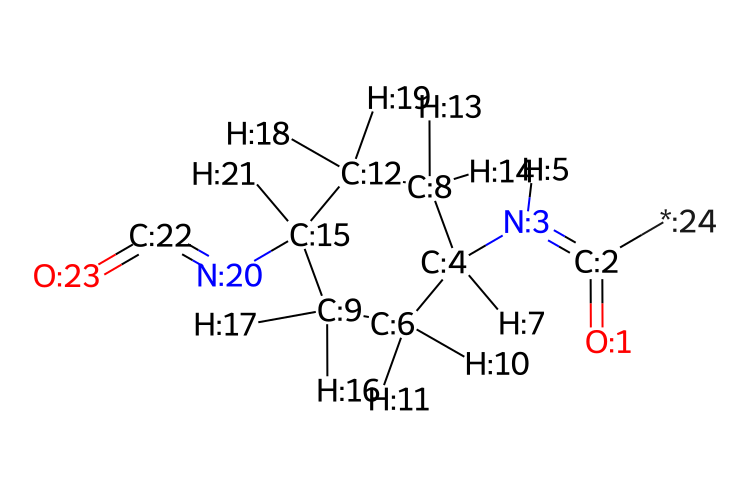

hydroxyl_TERM


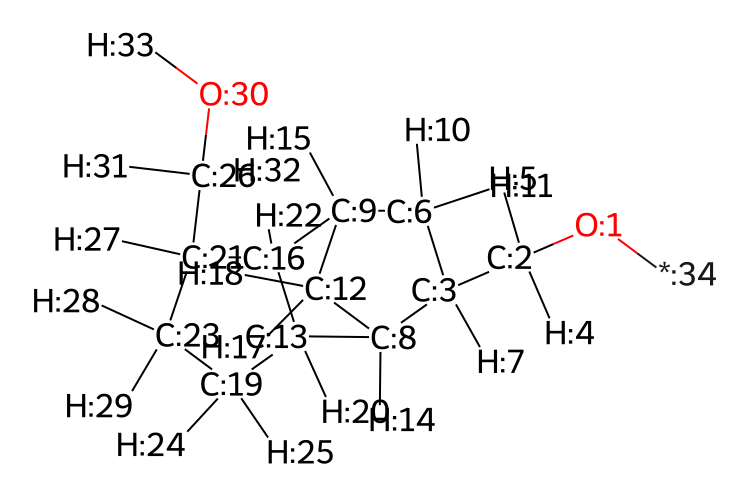

isocyanate_MID


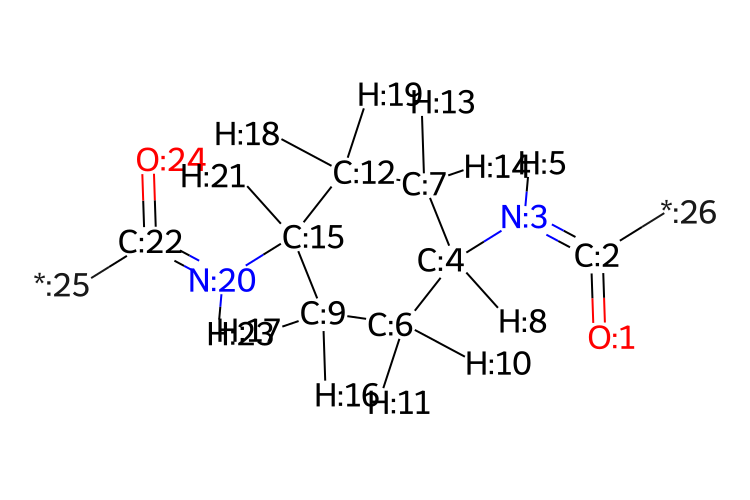

hydroxyl_MID


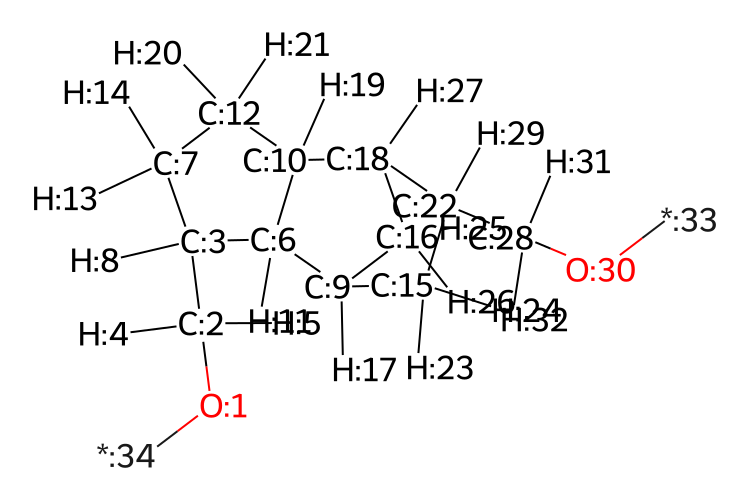

In [11]:
for resname, mol in monogrp.iter_rdmols():
    print(resname)
    display(mol)